# EDA

Let's first load our dataset from huggingface!

In [1]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset('rotten_tomatoes')

Using custom data configuration default
Reusing dataset rotten_tomatoes_movie_review (/home/chris/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
100%|██████████| 3/3 [00:00<00:00, 1502.62it/s]


Now let's immediately convert that to a pandas dataframe.

In [2]:
reviews_df = pd.DataFrame(dataset['train'])
reviews_df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


Let's start with some basic exploration, just to get a feel for what we're working with.

In [3]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Histogram(x=reviews_df['text'].str.split().str.len())])
fig.update_layout(title='Number of words in each review', bargap=0.2)
fig.show()

We can see that the number of words in each review is reasonably distributed, let's move onto some more in depth analysis of the words that appear in the reviews - it's time to bring in NLTK!

In [4]:
import nltk

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
review_words = reviews_df['text'].str.split().values.tolist()
review_corpus = [word for i in review_words for word in i]
print(f"Number of 'words' in the corpus: {len(review_corpus)}")
print(f"Number of 'unique words' in the corpus: {len(set(review_corpus))}")

Number of 'words' in the corpus: 179069
Number of 'unique words' in the corpus: 18951


In [6]:
from collections import Counter
review_word_counts = Counter(review_corpus)
ten_most_common_words = review_word_counts.most_common(20)

fig = go.Figure(data=[go.Bar(x=[word for word, count in ten_most_common_words if word.isalpha()], y=[count for word, count in ten_most_common_words if word.isalpha()])])
fig.update_layout(title='Ten most common words in the reviews', xaxis_title='Word', yaxis_title='Count')
fig.show()

This is an excellent example of why it's necessary to remove common stop words!

In [7]:
review_corpus_no_stop_or_punct = [word for word in review_corpus if word not in stop_words and word.isalpha()]
review_corpus_no_stop_or_punct_counts = Counter(review_corpus_no_stop_or_punct)
ten_most_common_words_no_stop_or_punct = review_corpus_no_stop_or_punct_counts.most_common(20)

# graph the ten most common words in the reviews without stop words or punctuation
fig = go.Figure(data=[go.Bar(x=[word for word, count in ten_most_common_words_no_stop_or_punct], y=[count for word, count in ten_most_common_words_no_stop_or_punct])])
fig.update_layout(title='Ten most common words in the reviews without stop words or punctuation', xaxis_title='Word', yaxis_title='Count')
fig.show()

In [8]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def top_n_ngrams(corpus, n=2, top_x=10):
    if top_x > len(corpus):
        raise ValueError('top_x cannot be greater than the length of the corpus')
    vector = CountVectorizer(ngram_range=(n, n), stop_words=None).fit(corpus)
    bag_of_words = vector.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_x]

Now, let's look at some n-grams. This should help us get a feel for seeing if there is a "review style" of writing.

In [9]:
top_10_bigrams = reversed(top_n_ngrams(review_corpus, n=2, top_x=10))
x, y = map(list, zip(*top_10_bigrams))
fig = go.Figure(data=[go.Bar(x=y, y=x, orientation='h')])
fig.update_layout(title='Top 10 bigrams in the reviews', xaxis_title='Count', yaxis_title='Bigram')
fig.show()

In [10]:
top_10_trigrams = reversed(top_n_ngrams(review_corpus, n=3, top_x=10))
x, y = map(list, zip(*top_10_trigrams))
fig = go.Figure(data=[go.Bar(x=y, y=x, orientation='h')])
fig.update_layout(title='Top 10 trigrams in the reviews', xaxis_title='Count', yaxis_title='Trigram')
fig.show()

Let's create a clean corpus that we can make a good word cloud out of!

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

def preprocess_corpus(review_dataframe):
    corpus = []
    tidf_corpus = []
    lem = nltk.WordNetLemmatizer()
    for review in review_dataframe['text']:
        words = [w for w in nltk.word_tokenize(review) if (w not in stop_words)]
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        tidf_corpus.append(" ".join(words))
        corpus.append(words)

    vectorizer = TfidfVectorizer(stop_words=None)
    vectorizer.fit_transform(tidf_corpus)
    tifdf_scores = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

    new_corpus = []
    for words in corpus:
        new_words = [w for w in words if (w in tifdf_scores and tifdf_scores[w] > 0.1)]
        new_corpus.append(new_words)
    return new_corpus

corpus = preprocess_corpus(reviews_df)

[nltk_data] Downloading package wordnet to /home/chris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
from collections import Counter

stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40,
        scale=3
    )

    # generate word cloud counter
    word_count = Counter()
    for words in data:
        word_count.update(words)
    
    wordcloud = wordcloud.generate_from_frequencies(word_count)
    fig = px.imshow(wordcloud)
    fig.show()

In [13]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
show_wordcloud(corpus)

Now let's do some Named Entity Recognition with spaCy!

In [14]:
!python -m spacy download en_core_web_sm

# remove the output clutter
from IPython.display import clear_output
clear_output()

In [15]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

In [16]:
for _ in range(5):
    review = reviews_df.sample(1)['text'].values[0]
    doc = nlp(review)
    displacy.render(doc, style='ent', jupyter=True)

/home/chris/anaconda3/envs/lemay-ai/lib/python3.10/site-packages/spacy/displacy/__init__.py:200: UserWarning:

[W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.



This kind of analysis proves to be slightly more difficult than it traditionally is, since movies/films might reference NEs specific to themselves. There's still some insight to be gather about the NEs that exist in our world, however.

In [17]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent = reviews_df['text'].apply(lambda x: ner(x))

ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common(10)

In [18]:
# plot the counts
count = reversed(count)
x, y = map(list, zip(*count))
fig = go.Figure(data=[go.Bar(x=y, y=x, orientation='h')])
fig.update_layout(title='Top 10 entities in the reviews', xaxis_title='Entity', yaxis_title='Count')
fig.show()

In [19]:
def ner_ent(text, ent="PERSON"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

person_ent = reviews_df['text'].apply(lambda x: ner_ent(x, ent="PERSON"))
person_ent = [x for sub in person_ent for x in sub]
counter = Counter(person_ent)

x, y = map(list, zip(*reversed(counter.most_common(10))))
fig = go.Figure(data=[go.Bar(x=y, y=x, orientation='h')])
fig.update_layout(title='Top 10 persons in the reviews', xaxis_title='Count', yaxis_title='Person')
fig.show()

In [20]:
norp_ent = reviews_df['text'].apply(lambda x: ner_ent(x, ent="NORP"))
norp_ent = [x for sub in norp_ent for x in sub]
counter = Counter(norp_ent)

x, y = map(list, zip(*reversed(counter.most_common(10))))
fig = go.Figure(data=[go.Bar(x=y, y=x, orientation='h')])
fig.update_layout(title='Top 10 NORPs in the reviews', xaxis_title='Count', yaxis_title='NORP')
fig.show()

Now, finally, let's look at the Flesch Kincaid Grade Level distribution for this dataset!

<AxesSubplot:>

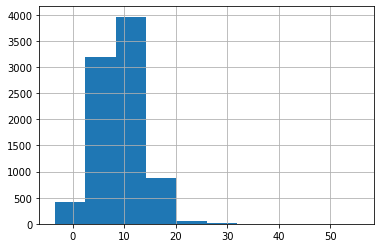

In [21]:
from textstat import flesch_kincaid_grade

reviews_df['text'].apply(lambda x: flesch_kincaid_grade(x)).hist()

As expected, a lot of the reviews tend to be around a Grade. 10 level - which indicates they are mostly short and approachable blocks of text.

(there are some noticeable exceptions, which are the reviews that one might describe as pedants)